# Exercise 06 CNN for Image Classification - Assignment

<span style="color:red">**The submission deadline of this assignment is February 11, 2024 23:59.**</span>

<span style="color:red">**In addition to the executed Jupyter Notebook, please also submit the saved `.pth` file of the trained CNN on Learn.**</span>

## Pedagogy

This notebook contains both theoretical explanations and executable cells to execute your code.

When you see the <span style="color:red">**[TBC]**</span> (To Be Completed) sign, it means that you need to perform an action else besides executing the cells of code that already exist. These actions can be:
- Complete the code with proper comments
- Respond to a question
- Write an analysis
- etc.

## Requirement

In this assignment, you are required to build a multi-class image classification model using CNN.

The problem to be solved is to classify RGB images into one of the 10 pre-defined classes:

![](https://production-media.paperswithcode.com/datasets/4fdf2b82-2bc3-4f97-ba51-400322b228b1.png)

<span style="color:red">**[TBC]**</span> Please complete the following tasks:
- Build the data pipeline
- Create a CNN-based image classifier
- Train the network
- Reload the best trained model
- Evaluation using test set

### Pre-configure

- Import necessary libraries
- Specify the computation device of PyTorch

In [3]:
# import libraries
import os
import datetime
import warnings

import torch
import numpy as np
import matplotlib.pyplot as plt

from sklearn.metrics import classification_report

from torch import nn
from torchvision import datasets, transforms
from torch.utils.data import TensorDataset, DataLoader, random_split

In [4]:
# get cpu, gpu or mps device for computation
device = (
    "cuda"
    if torch.cuda.is_available()
    else "mps"
    if torch.backends.mps.is_available()
    else "cpu"
)
print(f"Using {device} device")

Using mps device


## Task 1. Build the data pipeline

You are required to use the PyTorch built-in CIFAR10 dataset, consists of 60,000 $32\times32$ RGB images in 10 classes, with 6,000 images per class.

You can find more information about this dataset from the [PyTorch documentation](https://www.tensorflow.org/datasets/catalog/cifar10) and the [original source](https://www.cs.toronto.edu/~kriz/cifar.html).

<span style="color:red">**[TBC]**</span> You need to:
- Use `torchvision.datasets.CIFAR10()` to load the CIFAR10 dataset
- Use `torchvision.transforms.ToTensor()` to convert the data to tensors
- Divide the dataset into the training, valiation, and test set
- Create `DataLoader` instance to wrap the dataset as iterable objects
    - Decide a proper batch size considering
        - The available memory of your computer
        - The desired number of batches in each epoch

In [5]:
# load CIFAR10 dataset
train_val_ds = datasets.CIFAR10(
    root = 'data', # root directory for storing data
    train = True, # get the train part
    download = True,
    transform = transforms.ToTensor() # convert to tensor
)
test_ds = datasets.CIFAR10(
    root = 'data', # root directory for storing data
    train = False, # get the test part
    download = True,
    transform = transforms.ToTensor() # convert to tensor
)
train_ds, val_ds = random_split(
    train_val_ds,
    [0.8, 0.2] # [train size, val size]
)

Files already downloaded and verified
Files already downloaded and verified


In [6]:
# create data loaders
batch_size = 8192 # usually set to 2 to the nth power
train_dl = DataLoader(train_ds, batch_size = batch_size, shuffle = True)
val_dl = DataLoader(val_ds, batch_size = batch_size, shuffle = False)
test_dl = DataLoader(test_ds, batch_size = batch_size, shuffle = False)

In [7]:
# display the dimensionality of a batch
for (X, y) in val_dl:
    print('Feature shape:', X.shape)
    print('Label shape:', y.shape)
    break

Feature shape: torch.Size([8192, 3, 32, 32])
Label shape: torch.Size([8192])


Image sample 9


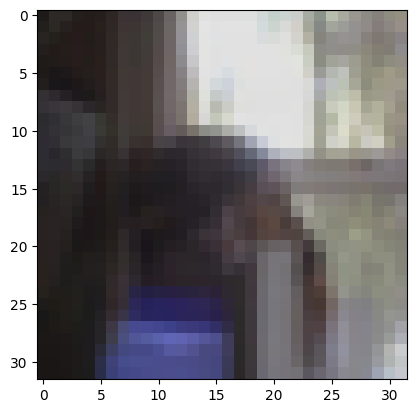

In [8]:
# display an example
plt.imshow(train_ds[6][0].numpy().transpose((1, 2, 0)))
print('Image sample', train_ds[7][1])

## Task 2. Create a CNN-based image classifier

<span style="color:red">**[TBC]**</span> You need to:
- Define a custom class to specify the structure of the network
    - You are required to use at least one convolutional layer in the network
    - Include batch normalization layer and dropout layer in the network
- Initialize the network and move it to the computation device

In [35]:
# define a custom neural network class
class CNNImageClassifier(nn.Module):
    def __init__(self, in_channels, n_labels):
        super().__init__()
        self.net = nn.Sequential(
            nn.LazyConv2d(out_channels = 3, kernel_size = 3, stride = 1, padding = 1),
            nn.LazyBatchNorm2d(), nn.ReLU(), nn.MaxPool2d(kernel_size = 2),
            nn.LazyConv2d(out_channels = 9, kernel_size = 3, stride = 1, padding = 1),
            nn.LazyBatchNorm2d(), nn.ReLU(), nn.MaxPool2d(kernel_size = 2),
            nn.LazyConv2d(out_channels = 27, kernel_size = 3, stride = 1, padding = 1),
            nn.LazyBatchNorm2d(), nn.ReLU(), nn.MaxPool2d(kernel_size = 2),
            nn.Flatten(),
            nn.LazyLinear(100), nn.LazyBatchNorm1d(), nn.ReLU(), nn.Dropout(p = 0.5),
            nn.LazyLinear(10)
        )

    def forward(self, x):
        return self.net(x)

In [36]:
# initialize the neural network
cnn_model = CNNImageClassifier(
    in_channels = train_ds[0][0].shape[0],
    n_labels = 10
)
cnn_model.to(device)

CNNImageClassifier(
  (net): Sequential(
    (0): LazyConv2d(0, 3, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): LazyBatchNorm2d(0, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (4): LazyConv2d(0, 9, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (5): LazyBatchNorm2d(0, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): ReLU()
    (7): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (8): LazyConv2d(0, 27, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): LazyBatchNorm2d(0, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): ReLU()
    (11): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (12): Flatten(start_dim=1, end_dim=-1)
    (13): LazyLinear(in_features=0, out_features=100, bias=True)
    (14): LazyBatchNorm1d(0, eps=1e-05, m

## Task 3. Train the network, save and reload the best one

<span style="color:red">**[TBC]**</span> You need to:
- Define a `train()` function and train the network
- Implement the weight decay, learning rate decay, early stopping, and automatic model saving
- Adjust the training hyper-parameters if necessary to get a good result
- Plot the loss history of the training process

In [11]:
# define the training function
def train(
    train_dl,
    val_dl,
    model,
    loss_fn,
    optimizer,
    epochs,
    early_stopping_patience,
    lr_scheduler,
    saved_path_prefix
):
    # initialization
    min_val_loss = np.inf
    patience_counter = 0
    histories = {
        'train_batch': [],
        'train_epoch': [],
        'val_batch': [],
        'val_epoch': []
    }
    saved_path = ''
    start_time = datetime.datetime.now() # record start time
    
    # start training
    for epoch in range(epochs):
        # train set
        train_epoch_loss = 0.0
        model.train() # set the model in training mode
        for (X, y) in train_dl:
            X, y = X.to(device), y.to(device)
            logits = model(X)
            train_batch_loss = loss_fn(logits, y)
            train_batch_loss.backward()
            optimizer.step()
            optimizer.zero_grad()
            histories['train_batch'].append(train_batch_loss.item())
            train_epoch_loss += train_batch_loss.item()
        train_epoch_loss /= len(train_dl)
        histories['train_epoch'].append(train_epoch_loss)
        
        # validation set
        val_epoch_loss = 0.0
        model.eval() # set the model in evaluation mode
        with torch.no_grad():
            for (X, y) in val_dl:
                X, y = X.to(device), y.to(device)
                logits = model(X)
                val_batch_loss = loss_fn(logits, y)
                histories['val_batch'].append(val_batch_loss.item())
                val_epoch_loss += val_batch_loss.item()
            val_epoch_loss /= len(val_dl)
            histories['val_epoch'].append(val_epoch_loss)

        # print log
        end_time = datetime.datetime.now()
        time_consumed = str(end_time - start_time).split('.')[0] # calculate consumed time after completing one epoch
        print(f"Epoch {epoch + 1}: train loss = {train_epoch_loss:>5f}, val loss = {val_epoch_loss:>5f}, time consumed = {time_consumed}")
        
        # learning rate decay
        current_lr = optimizer.param_groups[0]['lr']
        lr_scheduler.step(val_epoch_loss)
        new_lr = optimizer.param_groups[0]['lr']
        if current_lr != new_lr:
            print(f'Learning rate reduced after epoch {epoch+1}\n')
            
        # early stopping
        if val_epoch_loss < min_val_loss:
            min_val_loss = val_epoch_loss
            patience_counter = 0
            if os.path.exists(saved_path):
                os.remove(saved_path)
            time_str = datetime.datetime.now().strftime("%Y-%m-%d_%H-%M-%S")
            saved_path = saved_path_prefix + f'_epoch_{epoch+1}_val_loss_{val_epoch_loss:>4f}_{time_str}.pth'
            torch.save(model.state_dict(), saved_path)
            print(f'Model saved after epoch {epoch+1}\n')
        else:
            patience_counter += 1
        if patience_counter >= early_stopping_patience:
            print('Early stopping!')
            break
    return histories, saved_path

In [38]:
# define the training hyper-parameters
loss_fn = nn.CrossEntropyLoss()
learning_rate = 1e-1
weight_decay = 1e-5
epochs = 1000
early_stopping_patience = 20

# create a optimizer for cnn
optimizer = torch.optim.SGD(
    cnn_model.parameters(), # specify which model to optimize
    lr = learning_rate,
    weight_decay = weight_decay
)

# create a new LR scheduler for the new optimizer
lr_scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
    optimizer,
    mode = 'min',
    factor = 0.1,
    patience = 5
)

# set another prefix
saved_path_prefix = 'cnn_image_classifier'

In [39]:
# train the neural network
histories, saved_path = train(
    train_dl,
    val_dl,
    cnn_model, # specify which model to train
    loss_fn,
    optimizer,
    epochs,
    early_stopping_patience,
    lr_scheduler,
    saved_path_prefix
)

Epoch 1: train loss = 2.279897, val loss = 2.304526, time consumed = 0:00:04
Model saved after epoch 1

Epoch 2: train loss = 2.031604, val loss = 2.314578, time consumed = 0:00:06
Epoch 3: train loss = 1.923882, val loss = 2.333909, time consumed = 0:00:08
Epoch 4: train loss = 1.850132, val loss = 2.402421, time consumed = 0:00:11
Epoch 5: train loss = 1.797836, val loss = 2.350520, time consumed = 0:00:13
Epoch 6: train loss = 1.770559, val loss = 2.294162, time consumed = 0:00:15
Model saved after epoch 6

Epoch 7: train loss = 1.727460, val loss = 2.177529, time consumed = 0:00:17
Model saved after epoch 7

Epoch 8: train loss = 1.707662, val loss = 1.887736, time consumed = 0:00:20
Model saved after epoch 8

Epoch 9: train loss = 1.673904, val loss = 1.887086, time consumed = 0:00:22
Model saved after epoch 9

Epoch 10: train loss = 1.655998, val loss = 1.825120, time consumed = 0:00:24
Model saved after epoch 10

Epoch 11: train loss = 1.637272, val loss = 1.776563, time consume

In [40]:
# get the number of learning parameters
num_learning_params = sum(p.numel() for p in cnn_model.parameters() if p.requires_grad)
print(f"Number of learning parameters: {num_learning_params}")

Number of learning parameters: 47138


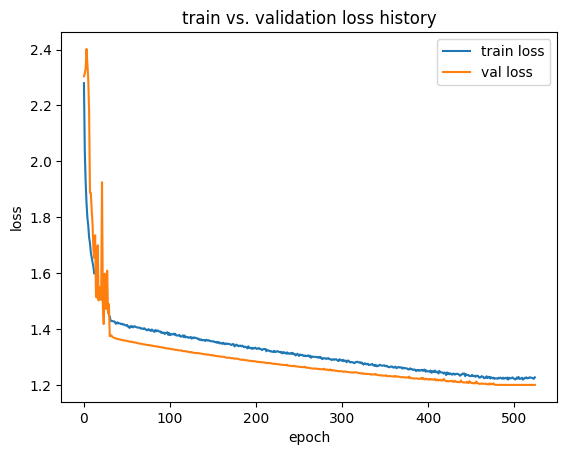

In [41]:
# plot the train vs. val loss history
plt.figure()
plt.plot(np.arange(len(histories['train_epoch'])), histories['train_epoch'], '-', label = 'train loss')
plt.plot(np.arange(len(histories['val_epoch'])), histories['val_epoch'], '-', label = 'val loss')
plt.title('train vs. validation loss history')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend()
plt.show()

## Task 4. Reload the best model

<span style="color:red">**[TBC]**</span> You need to:
- Reload the best trained model saved during the training process
- Move the reloaded model to the computation device

In [42]:
# reload model
cnn_model = CNNImageClassifier(
    in_channels = train_ds[0][0].shape[0],
    n_labels = 10
)
cnn_model.load_state_dict(torch.load(saved_path))
cnn_model.to(device)

/var/folders/12/4xknp3ds50l867z9m2bm4xpr0000gn/T/ipykernel_11429/1724207952.py:6: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  cnn_model.load_state_dict(torch.load(saved_pa

CNNImageClassifier(
  (net): Sequential(
    (0): LazyConv2d(0, 3, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): LazyBatchNorm2d(0, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (4): LazyConv2d(0, 9, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (5): LazyBatchNorm2d(0, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): ReLU()
    (7): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (8): LazyConv2d(0, 27, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): LazyBatchNorm2d(0, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): ReLU()
    (11): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (12): Flatten(start_dim=1, end_dim=-1)
    (13): LazyLinear(in_features=0, out_features=100, bias=True)
    (14): LazyBatchNorm1d(0, eps=1e-05, m

## Task 5. Evaluation using test set

<span style="color:red">**[TBC]**</span> You need to:
- Define the `test()` function
    - Output logits, probabilities and predictions
    - Output the loss value on the test set
- Make predictions on the test dataset
- Evaluate the performance
    - Use `sklearn.metrics.classification_report()`

In [17]:
# define a function to make predictions on test dataset and evaluate the performance
def test(dataloader, model, loss_fn):
    batch_logits_list = []
    batch_prob_list = []
    batch_pred_list = []
    model.eval()
    with torch.no_grad():
        loss = 0.0
        for (X, y) in dataloader:
            X, y = X.to(device), y.to(device)
            batch_logits = model(X)
            batch_loss = loss_fn(batch_logits, y)
            loss += batch_loss.item()
            batch_prob = torch.softmax(batch_logits, dim = -1)
            _, batch_pred = torch.max(batch_logits, 1)
            batch_logits_list.append(batch_logits.cpu().numpy())
            batch_prob_list.append(batch_prob.cpu().numpy())
            batch_pred_list.append(batch_pred.cpu().numpy())
        loss /= len(dataloader)
        logits = np.concatenate(batch_logits_list)
        prob = np.concatenate(batch_prob_list)
        pred = np.concatenate(batch_pred_list)
        print(f"test loss = {loss}")
    return logits, prob, pred, loss

In [44]:
# make prediction on test set and evaluate the performance
test_logits, test_prob, test_pred, test_loss = test(test_dl, cnn_model, loss_fn)

# obtain test labels
test_label = []
for (_, y) in test_dl:
    test_label.extend(y.cpu().numpy())

# calculate classification report
print(classification_report(test_label, test_pred))

test loss = 1.1836141347885132
              precision    recall  f1-score   support

           0       0.64      0.64      0.64      1000
           1       0.70      0.70      0.70      1000
           2       0.47      0.45      0.46      1000
           3       0.40      0.37      0.39      1000
           4       0.54      0.47      0.50      1000
           5       0.47      0.47      0.47      1000
           6       0.61      0.72      0.66      1000
           7       0.62      0.63      0.62      1000
           8       0.68      0.73      0.70      1000
           9       0.65      0.66      0.65      1000

    accuracy                           0.58     10000
   macro avg       0.58      0.58      0.58     10000
weighted avg       0.58      0.58      0.58     10000



In [20]:
# CIFAR-10 class names
class_names = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']

# map the predicted labels to class names
label = train_ds[0][1] + 1

test_pred_names = [class_names[label] for label in test_pred]

# Verify if the label corresponds to the class_name
print(f"Label: {label}, Class Name: {class_names[label - 1]}")

print('Unique predicted labels:', set(test_pred_names))
print('Unique predicted labels with their corresponding numbers:', {name: test_pred_names.count(name) for name in set(test_pred_names)})

Label: 5, Class Name: deer
Unique predicted labels: {'ship', 'cat', 'airplane', 'automobile', 'frog', 'truck', 'dog', 'horse', 'bird', 'deer'}
Unique predicted labels with their corresponding numbers: {'ship': 1068, 'cat': 644, 'airplane': 1009, 'automobile': 954, 'frog': 1305, 'truck': 1104, 'dog': 1214, 'horse': 1089, 'bird': 886, 'deer': 727}


The recognized image is: truck
The predicted probability is: 0.29907387


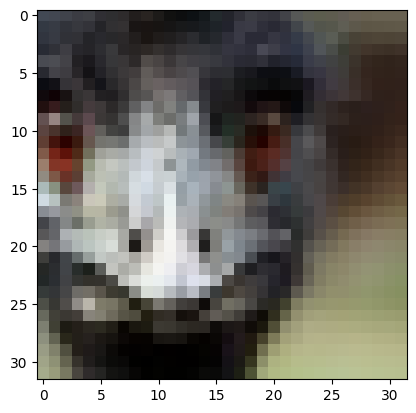

In [ ]:
# display an example
plt.imshow(test_ds[35][0].numpy().transpose((1, 2, 30)))
print('The recognized image is:', test_pred_names[35])
print('The predicted probability is:', test_prob[35, test_pred[35]])

## Making a deeper CNN

By adding more convolutional layers and fully connected layers making the network deeper and potentially more capable of learning complex patterns

In [30]:
class CNNImageClassifier(nn.Module):
    def __init__(self, in_channels, n_labels):
        super().__init__()
        self.net = nn.Sequential(
            nn.LazyConv2d(out_channels=3, kernel_size=3, stride=1, padding=1),
            nn.LazyBatchNorm2d(), nn.ReLU(), nn.MaxPool2d(kernel_size=2),
            nn.LazyConv2d(out_channels=9, kernel_size=3, stride=1, padding=1),
            nn.LazyBatchNorm2d(), nn.ReLU(), nn.MaxPool2d(kernel_size=2),
            nn.LazyConv2d(out_channels=27, kernel_size=3, stride=1, padding=1),
            nn.LazyBatchNorm2d(), nn.ReLU(), nn.MaxPool2d(kernel_size=2),
            nn.LazyConv2d(out_channels=81, kernel_size=3, stride=1, padding=1),  # Added layer
            nn.LazyBatchNorm2d(), nn.ReLU(), nn.MaxPool2d(kernel_size=2),  # Added layer
            nn.LazyConv2d(out_channels=243, kernel_size=3, stride=1, padding=1),  # Added layer
            nn.LazyBatchNorm2d(), nn.ReLU(), nn.MaxPool2d(kernel_size=2),  # Added layer
            nn.Flatten(),
            nn.LazyLinear(100), nn.LazyBatchNorm1d(), nn.ReLU(), nn.Dropout(p=0.5),
            nn.LazyLinear(50), nn.LazyBatchNorm1d(), nn.ReLU(), nn.Dropout(p=0.5),  # Added layer
            nn.LazyLinear(n_labels)
        )

    def forward(self, x):
        return self.net(x)

In [32]:
# initialize the neural network
cnn_model = CNNImageClassifier(
    in_channels = train_ds[0][0].shape[0],
    n_labels = 10
)
cnn_model.to(device)

CNNImageClassifier(
  (net): Sequential(
    (0): LazyConv2d(0, 3, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): LazyBatchNorm2d(0, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (4): LazyConv2d(0, 9, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (5): LazyBatchNorm2d(0, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): ReLU()
    (7): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (8): LazyConv2d(0, 27, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): LazyBatchNorm2d(0, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): ReLU()
    (11): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (12): LazyConv2d(0, 81, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): LazyBatchNorm2d(0, eps=1e-05, momentum=0.1, affine=True, tra

In [33]:
# define the training hyper-parameters
loss_fn = nn.CrossEntropyLoss()
learning_rate = 1e-2 # Reduced learning rate
weight_decay = 1e-5
epochs = 1500
early_stopping_patience = 30 # Increased patience

# create a optimizer for cnn
optimizer = torch.optim.SGD(
    cnn_model.parameters(), # specify which model to optimize
    lr = learning_rate,
    weight_decay = weight_decay
)

# create a new LR scheduler for the new optimizer
lr_scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
    optimizer,
    mode = 'min',
    factor = 0.1,
    patience = 5
)

# set another prefix
saved_path_prefix = 'cnn_image_classifier'

In [34]:
# train the neural network
histories, saved_path = train(
    train_dl,
    val_dl,
    cnn_model, # specify which model to train
    loss_fn,
    optimizer,
    epochs,
    early_stopping_patience,
    lr_scheduler,
    saved_path_prefix
)

Epoch 1: train loss = 2.433305, val loss = 2.307286, time consumed = 0:00:02
Model saved after epoch 1

Epoch 2: train loss = 2.392075, val loss = 2.312659, time consumed = 0:00:05
Epoch 3: train loss = 2.357619, val loss = 2.319522, time consumed = 0:00:07
Epoch 4: train loss = 2.324702, val loss = 2.326362, time consumed = 0:00:10
Epoch 5: train loss = 2.306749, val loss = 2.329155, time consumed = 0:00:12
Epoch 6: train loss = 2.286715, val loss = 2.313072, time consumed = 0:00:15
Epoch 7: train loss = 2.270704, val loss = 2.281662, time consumed = 0:00:17
Model saved after epoch 7

Epoch 8: train loss = 2.245507, val loss = 2.239865, time consumed = 0:00:20
Model saved after epoch 8

Epoch 9: train loss = 2.235426, val loss = 2.199441, time consumed = 0:00:22
Model saved after epoch 9

Epoch 10: train loss = 2.219517, val loss = 2.166710, time consumed = 0:00:25
Model saved after epoch 10

Epoch 11: train loss = 2.200842, val loss = 2.148115, time consumed = 0:00:27
Model saved aft

In [36]:
# get the number of learning parameters
num_learning_params = sum(p.numel() for p in cnn_model.parameters() if p.requires_grad)
print(f"Number of learning parameters: {num_learning_params}")

Number of learning parameters: 230690


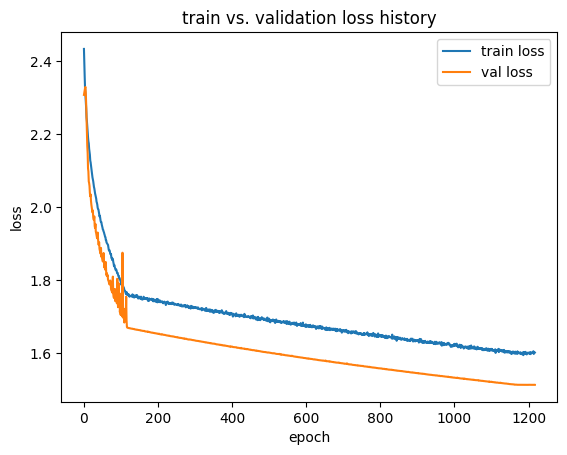

In [37]:
# plot the train vs. val loss history
plt.figure()
plt.plot(np.arange(len(histories['train_epoch'])), histories['train_epoch'], '-', label = 'train loss')
plt.plot(np.arange(len(histories['val_epoch'])), histories['val_epoch'], '-', label = 'val loss')
plt.title('train vs. validation loss history')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend()
plt.show()

In [38]:
# reload model
cnn_model = CNNImageClassifier(
    in_channels = train_ds[0][0].shape[0],
    n_labels = 10
)
cnn_model.load_state_dict(torch.load(saved_path))
cnn_model.to(device)

/var/folders/12/4xknp3ds50l867z9m2bm4xpr0000gn/T/ipykernel_11809/1724207952.py:6: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  cnn_model.load_state_dict(torch.load(saved_pa

CNNImageClassifier(
  (net): Sequential(
    (0): LazyConv2d(0, 3, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): LazyBatchNorm2d(0, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (4): LazyConv2d(0, 9, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (5): LazyBatchNorm2d(0, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): ReLU()
    (7): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (8): LazyConv2d(0, 27, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): LazyBatchNorm2d(0, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): ReLU()
    (11): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (12): LazyConv2d(0, 81, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): LazyBatchNorm2d(0, eps=1e-05, momentum=0.1, affine=True, tra

In [39]:
# make prediction on test set and evaluate the performance
test_logits, test_prob, test_pred, test_loss = test(test_dl, cnn_model, loss_fn)

# obtain test labels
test_label = []
for (_, y) in test_dl:
    test_label.extend(y.cpu().numpy())

# calculate classification report
print(classification_report(test_label, test_pred))

test loss = 1.5001364946365356
              precision    recall  f1-score   support

           0       0.57      0.52      0.54      1000
           1       0.54      0.67      0.60      1000
           2       0.42      0.22      0.29      1000
           3       0.34      0.20      0.25      1000
           4       0.41      0.40      0.41      1000
           5       0.39      0.52      0.45      1000
           6       0.45      0.58      0.51      1000
           7       0.51      0.59      0.55      1000
           8       0.57      0.64      0.60      1000
           9       0.57      0.49      0.53      1000

    accuracy                           0.48     10000
   macro avg       0.48      0.48      0.47     10000
weighted avg       0.48      0.48      0.47     10000



The recognized image is: automobile
The predicted probability is: 0.1499067


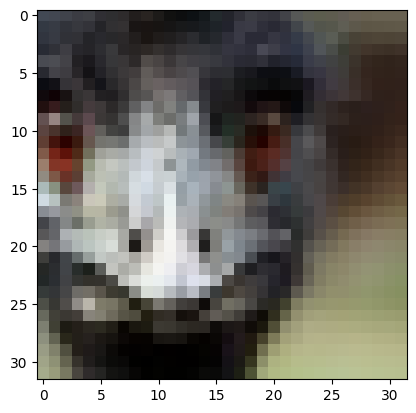

In [41]:
# display an example
plt.imshow(test_ds[35][0].numpy().transpose((1, 2, 0)))
print('The recognized image is:', test_pred_names[35])
print('The predicted probability is:', test_prob[35, test_pred[35]])

I tried to improve it, nevertheless eas not successful with the modifications I made. It is not clear to me which parameter could improve the accurancy of the model and but I would love to learn.